# PETR4 - Vamos construir nosso modelo de previsão baseando-se em um LSTM AutoEncoder para gerar as features e um classificador Gradient Boosting

In [1]:
stock_market = "PETR4"

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import pickle

from tensorflow.keras.models import save_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Explorando os dados

In [3]:
df = pd.read_csv('./bases/treino.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4808 entries, 0 to 4807
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          4808 non-null   int64  
 1   Date                4808 non-null   object 
 2   Close               4808 non-null   float64
 3   Smoothed_Close      4808 non-null   float64
 4   Label               4808 non-null   int64  
 5   Past_1_Days_Close   4808 non-null   float64
 6   Past_2_Days_Close   4808 non-null   float64
 7   Past_3_Days_Close   4808 non-null   float64
 8   Past_4_Days_Close   4808 non-null   float64
 9   Past_5_Days_Close   4808 non-null   float64
 10  Past_6_Days_Close   4808 non-null   float64
 11  Past_7_Days_Close   4808 non-null   float64
 12  Past_8_Days_Close   4808 non-null   float64
 13  Past_9_Days_Close   4808 non-null   float64
 14  Past_10_Days_Close  4808 non-null   float64
 15  Past_11_Days_Close  4808 non-null   float64
 16  Past_1

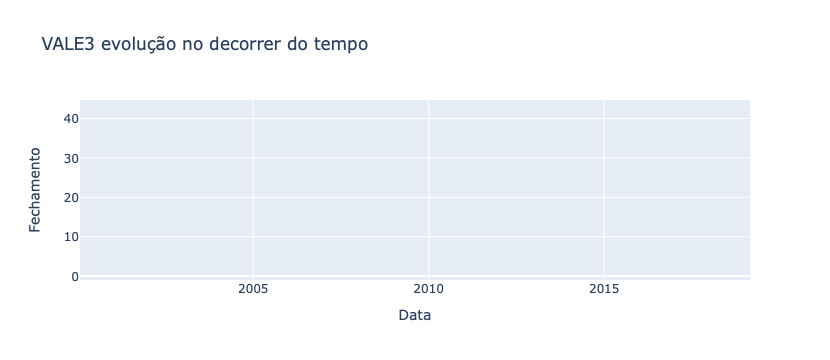

In [5]:
fig = px.line(df, x='Date', y='Close', title=f'{stock_market} evolução no decorrer do tempo')
fig.update_xaxes(title_text='Data')
fig.update_yaxes(title_text='Fechamento')
fig.show()

# Pré-processamento dos dados

In [4]:
seq_in_cols = ['Past_1_Days_Close',
'Past_2_Days_Close',
'Past_3_Days_Close',
'Past_4_Days_Close',
'Past_5_Days_Close',
'Past_6_Days_Close',
'Past_7_Days_Close',
'Past_8_Days_Close',
'Past_9_Days_Close',
'Past_10_Days_Close',
'Past_11_Days_Close',
'Past_12_Days_Close',
'Past_13_Days_Close',
'Past_14_Days_Close',
'Past_15_Days_Close']

seq_out_cols = ['Close',
'Past_1_Days_Close',
'Past_2_Days_Close',
'Past_3_Days_Close',
'Past_4_Days_Close',
'Past_5_Days_Close',
'Past_6_Days_Close',
'Past_7_Days_Close',
'Past_8_Days_Close',
'Past_9_Days_Close',
'Past_10_Days_Close',
'Past_11_Days_Close',
'Past_12_Days_Close',
'Past_13_Days_Close',
'Past_14_Days_Close']

df[seq_in_cols].values[0]

array([1.37588775, 1.47818375, 1.52251279, 1.56684077, 1.59411979,
       1.50034797, 1.54638124, 1.70494103, 1.7850734 , 1.86350036,
       1.84133625, 1.85327101, 1.77313876, 1.68277717, 1.65890777])

In [5]:
df[seq_out_cols].values[0]

array([1.40998626, 1.37588775, 1.47818375, 1.52251279, 1.56684077,
       1.59411979, 1.50034797, 1.54638124, 1.70494103, 1.7850734 ,
       1.86350036, 1.84133625, 1.85327101, 1.77313876, 1.68277717])

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(df[seq_in_cols], df[seq_out_cols], shuffle = False, train_size=0.8)

In [7]:
features = X_train.shape[1]

scalerX = MinMaxScaler(feature_range=(-1,1))
scalerX.fit(X_train)

X_train_scaled = scalerX.transform(X_train).reshape(-1, features, 1)
X_validation_scaled = scalerX.transform(X_validation).reshape(-1, features, 1)

scalerY = MinMaxScaler(feature_range=(-1,1))
scalerY.fit(y_train)

y_train_scaled = scalerY.transform(y_train).reshape(-1, features, 1)
y_validation_scaled = scalerY.transform(y_validation).reshape(-1, features, 1)

In [8]:
print('Train', X_train_scaled.shape)
print('Validation', X_validation_scaled.shape)

Train (3794, 15, 1)
Validation (949, 15, 1)


# Criando a arquitetura de nossa rede
- Arquitetura baseada no artigo [A Gentle Introduction to LSTM Autoencoders](https://machinelearningmastery.com/lstm-autoencoders/)

In [9]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(features, 1)))
lstm_model.add(RepeatVector(features))
lstm_model.add(LSTM(100, activation='relu', return_sequences=True))
lstm_model.add(TimeDistributed(Dense(1)))
lstm_model.compile(optimizer='adam', loss='mse')

# Treinando o modelo AutoEncoder
- Reutilizarei os valores de LearningRateScheduler e EarlyStopping de outro projeto com a esperança de se sairem bem

In [10]:
es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

hist = lstm_model.fit(
    x=X_train_scaled,
    y=y_train_scaled,
    validation_data=(X_validation_scaled, y_validation_scaled),
    batch_size=1,
    shuffle=False,
    epochs=300,
    verbose=1,
    callbacks=[es, red_lr]
)

Epoch 1/300
3794/3794 [==============================] - 42s 11ms/step - loss: 0.0052 - val_loss: 0.0332 - lr: 0.0010
Epoch 2/300
3794/3794 [==============================] - 40s 11ms/step - loss: 0.0022 - val_loss: 0.0366 - lr: 9.0000e-04
Epoch 3/300
3794/3794 [==============================] - 40s 11ms/step - loss: 0.0025 - val_loss: 0.0393 - lr: 8.1000e-04
Epoch 4/300
3794/3794 [==============================] - 40s 10ms/step - loss: 0.0034 - val_loss: 0.0335 - lr: 7.2900e-04
Epoch 5/300
3794/3794 [==============================] - 40s 11ms/step - loss: 0.0028 - val_loss: 0.0297 - lr: 6.5610e-04
Epoch 6/300
3794/3794 [==============================] - 40s 10ms/step - loss: 0.0024 - val_loss: 0.0268 - lr: 5.9049e-04
Epoch 7/300
3794/3794 [==============================] - 40s 10ms/step - loss: 0.0025 - val_loss: 0.0271 - lr: 5.3144e-04
Epoch 8/300
3794/3794 [==============================] - 40s 11ms/step - loss: 0.0024 - val_loss: 0.0230 - lr: 4.7830e-04
Epoch 9/300
3794/3794 [=====

# Salvando nosso modelo para usarmos mais tarde

In [15]:
lstm_filepath = 'lstm_autoencoder.pkl'
scalerX_filepath = 'scalerX.pkl'
scalerY_filepath = 'scalerY.pkl'

In [24]:
pickle.dump(lstm_model, open(lstm_filepath, 'wb'))
pickle.dump(scalerX, open(scalerX_filepath, 'wb'))
pickle.dump(scalerY, open(scalerY_filepath, 'wb'))

# Avaliando o modelo - Dataset de validação

In [17]:
yhat = lstm_model.predict(X_validation_scaled)
yhat.shape

31/31 [==============================] - 0s 6ms/step


(962, 15, 1)

In [18]:
df_yhat = pd.DataFrame(yhat.reshape(yhat.shape[0], yhat.shape[1]))
df_yhat_unscaled = pd.DataFrame(scalerY.inverse_transform(df_yhat))
df_yhat_unscaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,11.114681,11.139692,11.119928,11.061124,11.028697,10.979340,10.945709,10.916211,10.898789,10.886959,10.878426,10.872645,10.870516,10.881438,10.901355
1,11.178457,11.220957,11.214556,11.151959,11.107432,11.051722,11.006102,10.954698,10.912065,10.873458,10.837536,10.804148,10.774131,10.748618,10.728701
2,11.185548,11.228976,11.229024,11.169011,11.123039,11.070930,11.023780,10.965919,10.915293,10.867891,10.822801,10.780049,10.740580,10.705579,10.676335
3,11.158785,11.195266,11.196741,11.141273,11.100019,11.052113,11.008988,10.953359,10.904597,10.858782,10.815097,10.773593,10.735237,10.701231,10.672982
4,11.288927,11.368017,11.365618,11.280842,11.203201,11.128441,11.052639,10.973207,10.901322,10.833324,10.768185,10.706016,10.647797,10.594715,10.547887


In [19]:
print('RMSE', mean_squared_error(y_validation, df_yhat_unscaled))
print('MSE', mean_absolute_error(y_validation, df_yhat_unscaled))
print('MSE Percentage', mean_absolute_percentage_error(y_validation, df_yhat_unscaled))

RMSE 1.9205295646759502
MSE 0.6825981399538779
MSE Percentage 0.03123502761759285


# Analisando a distribuição da predição com o real

In [20]:
df_yhat_unscaled.describe().T[['mean', 'min', '50%', 'max']]

,mean,min,50%,max
0,19.237520,5.766686,18.268613,34.942734
1,18.921213,5.735031,18.271923,33.140053
2,19.063370,5.678317,18.312474,33.925735
3,19.302708,5.713359,18.290411,35.370850
4,19.489046,5.759330,18.195905,36.432640
5,19.653011,5.787738,18.100530,37.889111
6,19.740433,5.801225,18.095623,38.772106
7,19.781651,5.828222,18.082733,39.243874
8,19.791433,5.829931,17.944156,39.587086
9,19.781067,5.817907,17.927176,39.795658


In [21]:
y_validation.describe().T[['mean', 'min', '50%', 'max']]

,mean,min,50%,max
Close,20.032911,5.366714,18.371542,42.428528
Past_1_Days_Close,20.011327,5.366714,18.342354,42.428528
Past_2_Days_Close,19.989549,5.366714,18.314106,42.428528
Past_3_Days_Close,19.968598,5.366714,18.291259,42.428528
Past_4_Days_Close,19.947459,5.366714,18.256736,42.428528
Past_5_Days_Close,19.926775,5.366714,18.225351,42.428528
Past_6_Days_Close,19.906230,5.366714,18.215797,42.428528
Past_7_Days_Close,19.885392,5.366714,18.206382,42.428528
Past_8_Days_Close,19.864175,5.366714,18.202164,42.428528
Past_9_Days_Close,19.842998,5.366714,18.173919,42.428528


# Processando os dados para nosso classificador

Nossas features serão uma junção do:
- Encoder da sequencia de Close dos últimos 15 dias (100 posições)
- Close previsto pelo AutoEncoder

Totalizando 101 features

In [25]:
lstm_autoencoder = pickle.load(open(lstm_filepath, 'rb'))
lstm_encoder = Model(inputs=lstm_autoencoder.inputs, outputs=lstm_autoencoder.layers[0].output)

scalerX = pickle.load(open(scalerX_filepath, 'rb'))
scalerY = pickle.load(open(scalerY_filepath, 'rb'))

In [26]:
def pre_process_data_classifier(df):
    # Usando o AutoEncoder para gerar o Close para o próximo dia
    df_scaled = scalerX.transform(df[seq_in_cols]).reshape(-1, features, 1)

    df_decoded = lstm_autoencoder.predict(df_scaled)
    df_transformed = scalerY.inverse_transform(df_decoded.reshape(-1, features))
    df_close_predicted = pd.DataFrame(df_transformed)[0]

    df_predicted = pd.DataFrame({
        "Close Real": df['Close'],
        "Close Predicted": df_close_predicted,
        "Date": pd.to_datetime(df['Date'].values)
    })

    # Usando o Encoder para gerar features para o classificador
    df_encoded = lstm_encoder.predict(df_scaled)

    return pd.concat([pd.DataFrame(df_encoded), pd.DataFrame(df_close_predicted)], axis=1), df_predicted

In [27]:
test = pd.read_csv('./bases/teste.csv')

X_train, X_train_close = pre_process_data_classifier(df)
y_train = df['Label']
X_test, X_test_close = pre_process_data_classifier(test)
y_test = test['Label']

38/38 [==============================] - 0s 3ms/step


In [28]:
X_test_close.head()

,Close Real,Close Predicted,Date
0,32.196571,31.198591,2019-02-26
1,31.944181,31.386904,2019-02-27
2,32.128353,31.462402,2019-02-28
3,31.882784,31.398201,2019-03-01
4,32.776375,31.401384,2019-03-06


In [29]:
print('Train shape', X_train.shape)
print('Test shape', X_test.shape)

Train shape (4808, 101)
Test shape (1203, 101)


# Testando Classificadores

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC

def test_classifier(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return accuracy_score(y_test, pred)

classifiers_scores = [
    ('KNeighborsClassifier', test_classifier(KNeighborsClassifier())),
    ('DecisionTreeClassifier', test_classifier(DecisionTreeClassifier())),
    ('GradientBoostingClassifier', test_classifier(GradientBoostingClassifier())),
    ('AdaBoostClassifier', test_classifier(AdaBoostClassifier())),
    ('RandomForestClassifier', test_classifier(RandomForestClassifier())),
    ('GaussianNB', test_classifier(GaussianNB())),
    ('MultinomialNB', test_classifier(MultinomialNB())),
    ('Perceptron', test_classifier(Perceptron())),
    ('SGDClassifier', test_classifier(SGDClassifier())),
]

sorted_classifiers_scores = sorted(classifiers_scores, key=lambda x: x[1], reverse=True)
sorted_classifiers_scores

[('RandomForestClassifier', 0.6217788861180382),
 ('GradientBoostingClassifier', 0.6068162926018288),
 ('KNeighborsClassifier', 0.6051537822111388),
 ('AdaBoostClassifier', 0.5752285951787198),
 ('SGDClassifier', 0.5477971737323358),
 ('DecisionTreeClassifier', 0.542809642560266),
 ('Perceptron', 0.5320033250207814),
 ('GaussianNB', 0.512884455527847),
 ('MultinomialNB', 0.5020781379883624)]

# Tunando nosso classificador

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=3, verbose=2)

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

In [24]:
# print("Best Parameters:", best_parameters)
# print("Best Parameters:", best_score)

# Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100, 'subsample': 0.8}
# Best Parameters: 0.7085533262935586

# Treinando nosso GradientBoostingClassifier para predição de compra ou venda

In [31]:
classifier_model = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.2,
    max_depth=4,
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=100,
    subsample=0.8
)

classifier_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=4, min_samples_split=3,
                           random_state=42, subsample=0.8)

              precision    recall  f1-score   support

          -1       0.56      0.97      0.71       601
           1       0.89      0.25      0.38       602

    accuracy                           0.61      1203
   macro avg       0.72      0.61      0.55      1203
weighted avg       0.72      0.61      0.55      1203



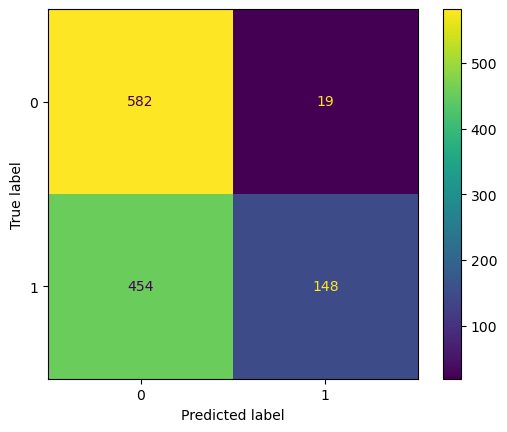

In [32]:
pred = classifier_model.predict(X_test)

print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Visualizando as predições

In [33]:
X_test_close['Signal'] = pred
X_test_close.head()

,Close Real,Close Predicted,Date,Signal
0,32.196571,31.198591,2019-02-26,1
1,31.944181,31.386904,2019-02-27,1
2,32.128353,31.462402,2019-02-28,1
3,31.882784,31.398201,2019-03-01,1
4,32.776375,31.401384,2019-03-06,1


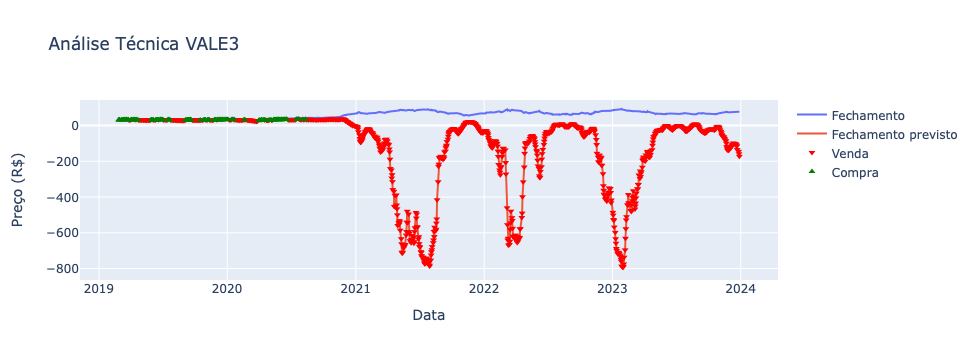

In [34]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test_close['Date'], y=X_test_close['Close Real'], mode='lines', name='Fechamento'))
fig.add_trace(go.Scatter(x=X_test_close['Date'], y=X_test_close['Close Predicted'], mode='lines', name='Fechamento previsto'))

# Adicionando marcadores para sinais de venda
fig.add_trace(go.Scatter(x=X_test_close[X_test_close['Signal'] == -1]['Date'], y=X_test_close[X_test_close['Signal'] == -1]['Close Predicted'],
                         mode='markers', marker_symbol='triangle-down', marker_color='red', name='Venda'))

# Adicionar marcadores para sinais de compra
fig.add_trace(go.Scatter(x=X_test_close[X_test_close['Signal'] == 1]['Date'], y=X_test_close[X_test_close['Signal'] == 1]['Close Predicted'],
                         mode='markers', marker_symbol='triangle-up', marker_color='green', name='Compra'))


fig.update_layout(title=f'Análise Técnica {stock_market}',
                  xaxis_title='Data',
                  yaxis_title='Preço (R$)')

fig.show()

# Realizando o Backing Test para verificar o desempenho monetário do modelo no periodo de teste

In [35]:
def follow_signal(cash, rates, signals):
    portfolio_value = []
    buyed_history = []
    wallet_history = []

    buy_value = 0
    wallet = cash
    buyed = 0
    for idx, buy in enumerate(signals):
        rate = rates[idx]
        if buy and wallet > 0:
            buy_value = rate
            buyed = wallet
            wallet = 0
        elif buy <= 0 and buyed > 0:
            variance_percentage = ((rate - buy_value)) / buy_value
            wallet = (buyed * variance_percentage) + buyed
            buyed = 0

        portfolio_value.append(buyed + wallet)
        buyed_history.append(buyed)
        wallet_history.append(wallet)

    profit_loss_percentage = (portfolio_value[-1] - cash) / cash
    profit_loss = cash * profit_loss_percentage
    total = profit_loss + cash

    return profit_loss_percentage, profit_loss, total, portfolio_value, wallet_history, buyed_history

def show_follow_signal_report(result, cash, rates, title=""):
        profit_loss_percentage, profit_loss, total, portfolio_value, wallet_history, buyed_history = result

        print(f"========== Follow Signal {title} ==========")
        print('Open Period $%.2f' % rates.iloc[0])
        print('Close Period $%.2f' % rates.iloc[-1])
        print('Period variation $%.2f' % (rates.iloc[-1] - rates.iloc[0]))
        print('Profit/Loss Percentage %.2f%%' % (profit_loss_percentage * 100))
        print('Applying $%.2f' % cash)
        print('Profit/Loss $%.2f' % profit_loss)
        print('Final amount $%.2f' % total)

def backing_test(df):
    cash = 1000 # Valor inicial investido
    rates = df['Close Real']
    signals = df['Signal']

    result = follow_signal(cash, rates, signals)
    show_follow_signal_report(result, cash, rates, stock_market)

In [36]:
backing_test(X_test_close)

========== Follow Signal VALE3 ==========
Open Period $32.20
Close Period $77.20
Period variation $45.00
Profit/Loss Percentage 279.17%
Applying $1000.00
Profit/Loss $2791.69
Final amount $3791.69


# Desempenho em 2023

In [37]:
df_2023 = X_test_close[X_test_close['Date'].dt.year == 2023].reset_index(drop=True)
backing_test(df_2023)

========== Follow Signal VALE3 ==========
Open Period $84.08
Close Period $77.20
Period variation $-6.88
Profit/Loss Percentage -22.56%
Applying $1000.00
Profit/Loss $-225.55
Final amount $774.45
